In [80]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict

In [167]:
class Tariff:
    def __init__(
        self,
        gas_sc: float,
        elec_sc: float,
        elec_unit: float,
        gas_unit: float,
        price_cap_schedule: List,
        buffer: int,
    ):
        self.gas_sc = gas_sc
        self.elec_sc = elec_sc
        self.elec_unit = elec_unit
        self.gas_unit = gas_unit
        self.price_cap_schedule = price_cap_schedule
        self.buffer = buffer
        self.monthly_elec_units, self.monthly_gas_units = self.project_unit_prices()

    def daily_cost(self, gas_usage: float, elec_usage: float) -> float:
        return self.gas_daily_cost(gas_usage) + self.elec_daily_cost(elec_usage)

    def gas_daily_cost(self, gas_usage: float) -> float:
        return self.gas_sc + self.gas_unit * gas_usage

    def elec_daily_cost(self, elec_usage: float) -> float:
        return self.elec_sc + self.elec_unit * elec_usage

    def period_cost(self, days: int, gas_usage: float, elec_usage: float) -> float:
        # sum total cost over period
        daily_gas = gas_usage / days
        daily_elec = elec_usage / days
        return self.daily_cost(daily_gas, daily_elec) / 100

    def increase_unit_rate(self, frac: float) -> None:
        # update the unit rates
        self.elec_unit += self.elec_unit * frac
        self.gas_unit += self.gas_unit * frac

    def project_unit_prices(self) -> Tuple[List, List]:
        """Incorperate projected 3-monthly price cap rises into forecast

        :return Tuple[List, List]: gas + elec monthly unit charges
        """
        # self.price_cap_schedule contains 3-monthly projected changes in unit charges
        monthly_elec_units = [self.elec_unit for _ in range(12)]
        monthly_gas_units = [self.gas_unit for _ in range(12)]
        for idx, buf in enumerate([0, 3, 6, 9]):
            monthly_elec_units[self.buffer + buf :] = [
                i * self.price_cap_schedule[idx]
                for i in monthly_elec_units[self.buffer + buf :]
            ]
            monthly_gas_units[self.buffer + buf :] = [
                i * self.price_cap_schedule[idx]
                for i in monthly_gas_units[self.buffer + buf :]
            ]
        return monthly_elec_units, monthly_gas_units

    def run_annual_forecast(self, elec_usage: List, gas_usage: List) -> Dict:

        # predict monthly costs
        gas_usage = np.array(gas_usage)
        elec_usage = np.array(elec_usage)
        monthly_elec = []
        monthly_gas = []
        for i in range(12):
            monthly_gas.append(
                self.gas_sc * 30.437 + self.monthly_gas_units[i] * gas_usage[i]
            )
            monthly_elec.append(
                self.elec_sc * 30.437 + self.monthly_elec_units[i] * elec_usage[i]
            )
        monthly_elec = np.array(monthly_elec) / 100
        monthly_gas = np.array(monthly_gas) / 100
        total_gas = np.round(np.sum(monthly_gas), 2)
        total_elec = np.round(np.sum(monthly_elec), 2)
        print(
            "Total annual gas:    £",
            total_gas,
            "\nTotal annual elec:   £",
            total_elec,
            "\n-------------------------------",
            "\nTotal annual energy: £",
            total_gas + total_elec,
            "\n\n"
        )
        return {"gas": monthly_gas, "elec": monthly_elec}, total_elec + total_gas

In [195]:
evergreen = Tariff(
    # elec_sc=41.66,
    # gas_sc=27.22,
    elec_sc=48.18,
    gas_sc=27.53,
    elec_unit=29.29,
    gas_unit=7.32,
    price_cap_schedule=[1.82, 1.19, 1.04, 0.86],
    buffer=1,
)

In [196]:
fixed = Tariff(
    elec_sc=48.18,
    gas_sc=27.53,
    elec_unit=58.59,
    gas_unit=16.74,
    price_cap_schedule=[1, 1, 1, 1],
    buffer=0,
)

In [197]:
gas_rng = range(10000, 14000, 1000)
elec_rng = range(2000, 5000, 1000)

In [198]:
# flex_data = []
# for g in gas_rng:
#     for e in elec_rng:
#         _, total = evergreen.run_annual_forecast(
#             elec_usage=[e / 12 for _ in range(12)],
#             gas_usage=[g / 12 for _ in range(12)],
#         )
#         flex_data.append(total)

In [199]:
# fix_data = []
# for g in gas_rng:
#     for e in elec_rng:
#         _, total = fixed.run_annual_forecast(
#             elec_usage=[e / 12 for _ in range(12)],
#             gas_usage=[g / 12 for _ in range(12)],
#         )
#         fix_data.append(total)

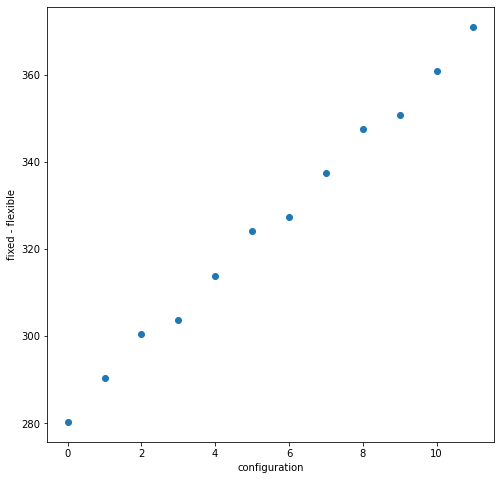

In [200]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter([x for x in range(len(fix_data))], np.array(fix_data) - np.array(flex_data))
ax.set_ylabel("fixed - flexible")
ax.set_xlabel("configuration")
plt.show()

Total annual gas:    £ 2109.35 
Total annual elec:   £ 1640.72 
------------------------------- 
Total annual energy: £ 3750.0699999999997 


Total annual gas:    £ 1827.26 
Total annual elec:   £ 1615.39 
------------------------------- 
Total annual energy: £ 3442.65 




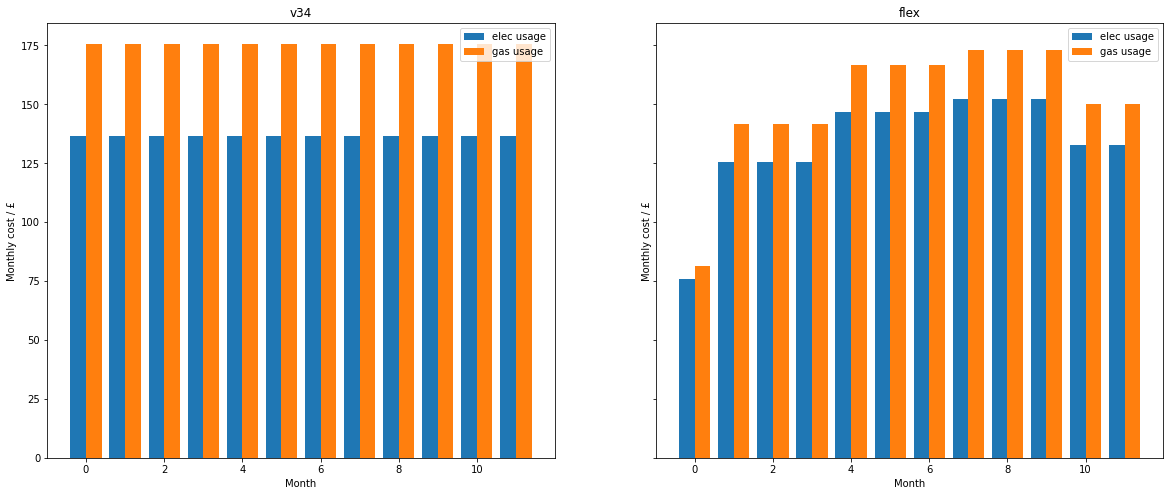

In [201]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
data = [
    fixed.run_annual_forecast(
        elec_usage=[2500 / 12 for _ in range(12)],
        gas_usage=[12000 / 12 for _ in range(12)],
    ),
    evergreen.run_annual_forecast(
        elec_usage=[2500 / 12 for _ in range(12)],
        gas_usage=[12000 / 12 for _ in range(12)],
    ),
]
title = ["v34", "flex"]
for idx, ax in enumerate(axes.flatten()):
    x = [i for i in range(12)]
    ax.bar([i - 0.2 for i in x], data[idx][0]["elec"], width=0.4, label="elec usage")
    ax.bar([i + 0.2 for i in x], data[idx][0]["gas"], width=0.4, label="gas usage")
    ax.legend()
    ax.set_title(title[idx])
    ax.set_ylabel("Monthly cost / £")
    ax.set_xlabel("Month")
plt.show()